# Imports and setting up viz

NB : conda env1 on Mac, lam1env on spirit (Python3.12)

In [112]:
import numpy as np
import scipy as sc
import netCDF4 as nc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import cartopy.crs as ccrs
import cartopy
import matplotlib as mpl
from matplotlib.colors import ListedColormap
%matplotlib inline

In [83]:
plt.rcParams.update(
        {
            'figure.facecolor': 'white',
            'axes.facecolor': 'white',
            'font.size': 12,
            'figure.dpi': 72.0,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.size': 5.0,
            'xtick.minor.size': 2.5,
            'ytick.major.size': 5.0,
            'ytick.minor.size': 2.5,
            'xtick.minor.visible': True,
            'ytick.minor.visible': True,
            'axes.grid': True,
            'axes.titlesize': 'larger',
            'axes.labelsize': 'larger',
            'grid.color': 'dimgray',
            'grid.linestyle': '-',
            'grid.alpha': 0.3,
            'axes.prop_cycle': cycler(
                color=[
                    '#0C5DA5',
                    '#FF9500',
                    '#00B945',
                    '#FF2C00',
                    '#845B97',
                    '#474747',
                    '#9E9E9E',
                ]
            ) * cycler(alpha=[0.8]),
            'scatter.marker': 'x',
            'lines.linewidth': 1.0,
        })

In [84]:
rivers = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',edgecolor=(0, 0, 0, 0.3), facecolor='none')

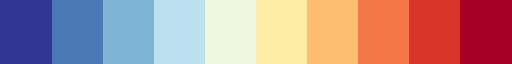

In [85]:
#define centered colorbar
emb = ListedColormap(mpl.colormaps['RdYlBu_r'](np.linspace(0, 1, 10)))
emb

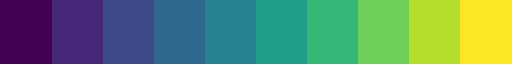

In [86]:
#define progressive colorbar
myvir = ListedColormap(mpl.colormaps['viridis'](np.linspace(0, 1, 10)))
myvir

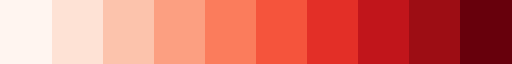

In [87]:
#define progressive colorbar
reds = ListedColormap(mpl.colormaps['Reds'](np.linspace(0, 1, 10)))
reds

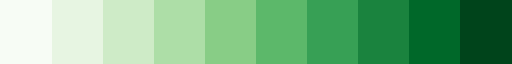

In [88]:
#define progressive colorbar
greens = ListedColormap(mpl.colormaps['Greens'](np.linspace(0, 1, 10)))
greens

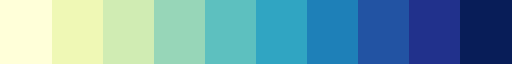

In [89]:
#define progressive colorbar
wet = ListedColormap(mpl.colormaps['YlGnBu'](np.linspace(0, 1, 10)))
wet

# Load files

LAM output analysis.

simu irr et simu no-irr.

In [90]:
noirr_dir='../../../JZ_simu_outputs/LAM/noirr_2010_2022'

In [91]:
#open netcdf files for native routing on ORC grid
filename = '{}/SRF/MO/*history.nc'.format(noirr_dir)
ORC0 = xr.open_mfdataset(filename)
ORC0

<xarray.Dataset>
Dimensions:                 (lat: 232, lon: 300, veget: 15, soiltyp: 3,
                             solth: 18, nobio: 1, solay: 11, albtyp: 2,
                             time_counter: 156, axis_nbounds: 2)
Coordinates:
  * lat                     (lat) float32 30.0 30.09 30.17 ... 49.83 49.91 50.0
  * lon                     (lon) float32 -13.0 -12.93 -12.86 ... 7.86 7.93 8.0
  * veget                   (veget) float32 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * soiltyp                 (soiltyp) float32 1.0 2.0 3.0
  * solth                   (solth) float32 0.0004888 0.001955 ... 33.53 65.56
  * nobio                   (nobio) float32 1.0
  * solay                   (solay) float32 0.0 0.001955 0.005865 ... 0.999 2.0
  * albtyp                  (albtyp) float32 1.0 2.0
    time_centered           (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter            (time_counter) datetime64[ns] 2010-01-16T12:00:00...
Dimensions without coordinates: axis_nbounds
Data variables: (12/119)
    time_centered_bounds    (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds     (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                   (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    Contfrac                (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    swnet                   (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    lwnet                   (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    ...                      ...
    DelSWE_daily            (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delfastr_daily          (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delslowr_daily          (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delstreamr_daily        (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delstock_routing_daily  (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    soilalb_bg              (time_counter, albtyp, lat, lon) float32 dask.array<chunksize=(1, 2, 232, 300), meta=np.ndarray>
Attributes:
    name:         sechiba_history
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Apr-08 20:50:55 GMT
    uuid:         8b9758b9-e8f3-4e3f-ae48-7add1398362f

In [92]:
#open histmth files
filename = '{}/ATM/TS*.nc'.format(noirr_dir)
# filename='/data/ptiengou/JZ_simu_outputs/LAM/noirr_2010_2022/ATM/TS_MO_noirr_precip.nc'
sim0 = xr.open_mfdataset(filename)
sim0

<xarray.Dataset>
Dimensions:            (time_counter: 156, bnds: 2, lon: 200, lat: 200)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... ...
  * lon                (lon) float32 -13.0 -12.89 -12.79 ... 7.789 7.894 8.0
  * lat                (lat) float32 30.0 30.1 30.2 30.3 ... 49.7 49.8 49.9 50.0
Dimensions without coordinates: bnds
Data variables:
    time_counter_bnds  (time_counter, bnds) datetime64[ns] dask.array<chunksize=(156, 2), meta=np.ndarray>
    contfracATM        (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    evap               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    flat               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    precip             (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    sens               (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
    t2m                (time_counter, lat, lon) float32 dask.array<chunksize=(156, 200, 200), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    name:         histmth
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2024-Apr-08 20:51:45 GMT
    uuid:         a5b46127-ad8e-4c7a-aabe-d52f3173c847
    history:      Thu Jun 13 15:23:02 2024: cdo mergetime sim14_contfracATM.n...
    NCO:          netCDF Operators version 5.0.7 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

<xarray.Dataset>
Dimensions:    (longitude: 77, latitude: 69, time: 156)
Coordinates:
  * longitude  (longitude) float32 -13.0 -12.75 -12.5 -12.25 ... 5.5 5.75 6.0
  * latitude   (latitude) float32 49.0 48.75 48.5 48.25 ... 32.5 32.25 32.0
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-16 10:03:54 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [94]:
#open fluxcom and gleam
filename='/data/ptiengou/obs/E_1980-2022_GLEAM_v3.8a_MO.nc'
gleam0=xr.open_dataset(filename)
gleam0

<xarray.Dataset>
Dimensions:  (time: 516, lon: 1440, lat: 720)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2022-12-31
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
Data variables:
    E        (time, lat, lon) float32 ...

In [95]:
# filename='/data/ptiengou/obs/FluxCom/LE.RS.EBC-ALL.MLM-ALL.METEO-NONE.720_360.monthly.2013.nc'
# fluxcom=xr.open_mfdataset(filename)
# fluxcom

# File manipulations

In [96]:
#orc
#name
ORC0.attrs['name'] = 'simORC'
#time counter
ORC = ORC0.rename({'time_counter':'time'})
#define vars
ORC['totrunoff'] = ORC['runoff'] + ORC['drainage']
# limit data to lon and lat of interest (-13,6) and (32,49)
# ORC = ORC.sel(lon=slice(-13,6),lat=slice(32,49))

In [97]:
#sim
sim0.attrs['name'] = 'sim_noIrr'
sim = sim0.rename({'time_counter':'time'})
sim = sim.sel(lon=slice(-13,6),lat=slice(32,49))

In [144]:

sim['evap'] = sim['evap'] *3600 * 24
sim['precip'] = sim['precip'] *3600 * 24

In [122]:
#open ERA5 file
filename = '../../../obs/ERA5_eval_2010_2022.nc'
era = xr.open_mfdataset(filename)
era.attrs['name'] = 'ERA5'
#define or edit vars
#name ERA5 vars like in LMDZOR outputs
dict =  {
        'longitude':'lon',
        'latitude':'lat',
        'e':'evap',
        'ro':'totrunoff',
        'tp':'precip'
        }
era = era.rename(dict)

#make evap positive in era
era['evap'] = -era['evap'] * 1000
era['evap'].attrs['units'] = 'mm'
era['precip'] = era['precip']*1000
era['precip'].attrs['units'] = 'mm'
era


<xarray.Dataset>
Dimensions:    (lon: 77, lat: 69, time: 156)
Coordinates:
  * lon        (lon) float32 -13.0 -12.75 -12.5 -12.25 ... 5.25 5.5 5.75 6.0
  * lat        (lat) float32 49.0 48.75 48.5 48.25 ... 32.75 32.5 32.25 32.0
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
Data variables:
    u10        (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    v10        (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    evap       (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    totrunoff  (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
    precip     (time, lat, lon) float32 dask.array<chunksize=(156, 69, 77), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-16 10:03:54 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...
    name:         ERA5

In [99]:
#gleam
gleam0.attrs['name']='GLEAM'
gleam = gleam0.sel(lon=slice(-13,6),lat=slice(49,32))
#adapt period
gleam=gleam.sel(time=slice('2010-01-01', '2022-12-31'))
#name gleam vars like in LMDZOR outputs
dict =  {
        'E':'evap'
        }
gleam = gleam.rename(dict)
#convert mm/month to mm/day
gleam['evap']=gleam['evap']/30
gleam['evap'].attrs['units']='mm/d'
gleam

<xarray.Dataset>
Dimensions:  (time: 156, lon: 76, lat: 68)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2022-12-31
  * lon      (lon) float64 -12.88 -12.62 -12.38 -12.12 ... 5.375 5.625 5.875
  * lat      (lat) float64 48.88 48.62 48.38 48.12 ... 32.88 32.62 32.38 32.12
Data variables:
    evap     (time, lat, lon) float32 nan nan nan nan ... 0.06059 0.05702 0.0631
Attributes:
    name:     GLEAM

In [100]:
# Select the JJA months (June, July, August)
# ORC = ORC.sel(time=ORC['time.month'].isin([6, 7, 8]))
# ORCnoirr = ORCnoirr.sel(time=ORCnoirr['time.month'].isin([6, 7, 8]))
#sim = sim.sel(time=sim['time.month'].isin([6, 7, 8]))
#sim = sim.sel(time=sim['time.month'].isin([6, 7, 8]))

In [101]:
#use masks
con_mask=sim['contfracATM']>0

In [151]:
contSim=sim.where(con_mask)

In [123]:
#interpolate era
intEra=era.interp_like(sim)
contEra=intEra.where(con_mask)

In [156]:
intGleam=gleam.interp_like(sim)

# Maps

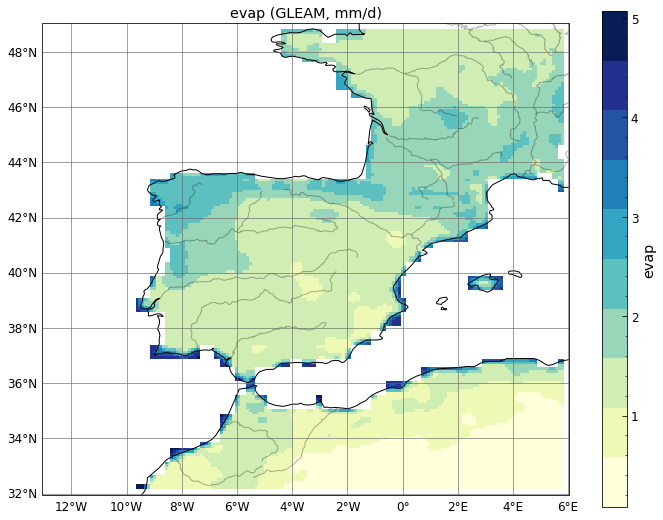

In [157]:
#Display map of var for ds
var='evap'
ds=intGleam
color_map=wet
max_value=None
plotvar = ds[var].mean(dim='time') #*3600*24
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=color_map, vmax=max_value)
plt.title(var + ' ({}, {})' .format(ds.attrs['name'], ds[var].attrs['units']))
# plt.title('Applied irrigation (mm/day)')# ({})' .format(ds[var].attrs['units']))
plt.tight_layout()

In [ ]:
#Display map of var for ds on restricted area
var='evap'
ds = sim
# ds = std
latmin=36.7
latmax=36.9
lonmin=-6.4
lonmax=-6.2

#restrict ds to latmin, latmax, lonmin, lonmax
ds = ds.where(ds.lat >= latmin, drop=True)
ds = ds.where(ds.lat <= latmax, drop=True)
ds = ds.where(ds.lon >= lonmin, drop=True)
ds = ds.where(ds.lon <= lonmax, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=reds)
plt.title(var + ' (' + ds.name + ')')

In [ ]:
#Display map of var for ds averaged on a given year
var='hydrographs'
year=2012
ds = sim
# ds = ds.where(ds['time.year'] == year, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=myvir)
plt.title(var + ' (' + ds.name + ')')

Text(0.5, 1.0, 'Evaporation difference (mm/day)')

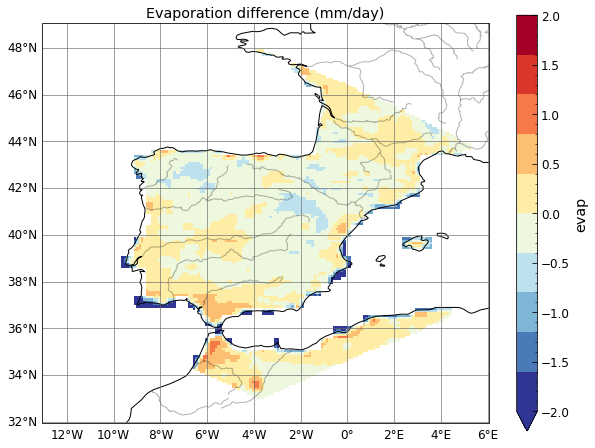

In [162]:
#Diff map
var='evap'
max_value=2
ds1=contEra
ds2=intGleam
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time') #* 3600 * 24
#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)

diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=max_value)
# plt.title(var + ' difference (' + ds1.name + ' - ' + ds2.name + ', ' + ds1[var].attrs['units'] + ')')
plt.title('Evaporation difference (mm/day)')

In [ ]:
#Relative diff map
var='sfcWind'
maxvalue=None
ds1=sim
ds2=sim
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time')
rel_diff = ((ds1[var]-ds2[var] + 1E-16) / (ds2[var] + 1E-16)).mean(dim='time') * 100
# Transform rel_diff using log10
rel_diff_log = np.log10(rel_diff)
#display map
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
rel_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=maxvalue)
# rel_diff_log.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb)
plt.title(var + ' relative difference (' + ds1.name + ' - ' + ds2.name + '; %)')
# plt.title('Gross primary production relative difference (%)')

Text(0.5, 1.0, 'evap (ERA5)')

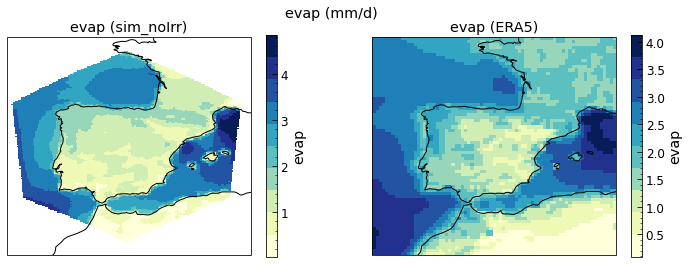

In [145]:
# Display 2 maps of var
var = 'evap'
minvalue=None
maxvalue=None
color_map=wet

ds1 = sim
ds2 = era
plotvar_1 = ds1[var].mean(dim='time') #*1000 #*3600*24
plotvar_2 = ds2[var].mean(dim='time') #*3600*24

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(var + ' (mm/d)')#.format(ds1[var].units))

# Plot for std dataset
axs[0].coastlines()
plotvar_1.plot(ax=axs[0], transform=ccrs.PlateCarree(), cmap=color_map, vmin=minvalue, vmax=maxvalue)
axs[0].set_title(f'{var} ({ds1.name})')

# Plot for natORC dataset
axs[1].coastlines()
plotvar_2.plot(ax=axs[1], transform=ccrs.PlateCarree(), cmap=color_map, vmin=minvalue, vmax=maxvalue)
axs[1].set_title(f'{var} ({ds2.name})')

In [ ]:
# create map of wind as vector combining u and v components
ds = sim
dist=6

#compute wind speed
wind_speed = (ds['u850'][0,:,:]**2 + ds['v850'][0,:,:]**2)**(1/2)
#extract x and y (u and v) components and reduce dimension
windx = ds['u850'][0,::dist,::dist]
windy = ds['v850'][0,::dist,::dist]
longi=ds['lon'][::dist]
lati=ds['lat'][::dist]
# wind_speed=(windx**2+windy**2)**(1/2)
# longi,lati=np.meshgrid(longi,lati)

#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
#use colormap reds
wind_speed.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=reds)
ax.quiver(longi, lati, windx, windy, transform=ccrs.PlateCarree(), scale=100)
plt.title('850hPa wind speed (m/s) and direction in Irr ORCulation')
plt.show()


In [ ]:
# wind difference
ds1 = sim
ds2 = sim
dist=6

#compute wind speed
wind_speed1 = (ds1['u850'][0,:,:]**2 + ds1['v850'][0,:,:]**2)**(1/2)
wind_speed2 = (ds2['u850'][0,:,:]**2 + ds2['v850'][0,:,:]**2)**(1/2)
wind_speed_diff = wind_speed1 - wind_speed2
#extract x and y (u and v) components and reduce dimension
longi=ds['lon'][::dist]
lati=ds['lat'][::dist]
windx1 = ds1['u850'][0,::dist,::dist]
windy1 = ds1['v850'][0,::dist,::dist]
windx2 = ds2['u850'][0,::dist,::dist]
windy2 = ds2['v850'][0,::dist,::dist]
windx_diff = windx1 - windx2
windy_diff = windy1 - windy2


#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
#use colormap reds
wind_speed_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb)
ax.quiver(longi, lati, windx_diff, windy_diff, transform=ccrs.PlateCarree(), scale=10)
plt.title('850hPa wind speed (m/s) and direction difference')
plt.show()


# Time series

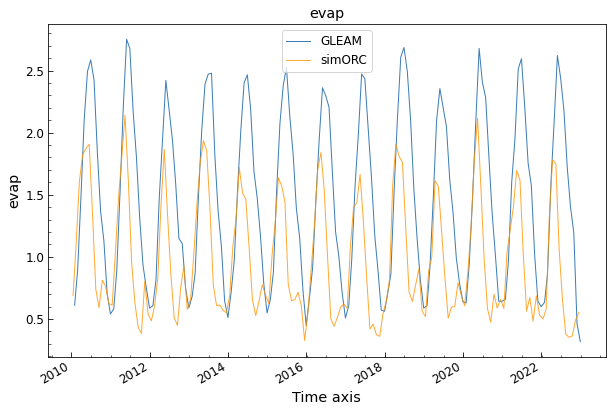

In [48]:
#Average time series
var='evap'
ds1=gleam
ds2=ORC
ds3=era
ds4=sim
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
(ds1[var]*1).mean(dim=['lon','lat']).plot(ax=ax, label=ds1.name)
(ds2[var]*1).mean(dim=['lon','lat']).plot(ax=ax, label=ds2.name)
# (ds3[var]*1000).mean(dim=['lon','lat']).plot(ax=ax, label=ds3.name)
# (ds4[var]*3600*24).mean(dim=['lon','lat']).plot(ax=ax, label=ds4.name)
plt.title(var)
plt.legend()

In [ ]:
#Average seasonnal cycle
var='evap'
ds1=sim
ds2=sim
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ds1[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds1.name)
ds2[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds2.name)
plt.title(var)
plt.legend()